In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,location_specific_linear, CustomPenalizedMixtureDecisionModel, get_mixture
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix, cross_ratio_decision, get_perturbed_bpr_func
from experiments import training_loop, training_loop_score_function_trick, score_function_trick, overall_gradient_calculation
from plotting_funcs import plot_losses, plot_frontier, sample_and_plot

import scipy

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt
import resource
import datetime
import time

2024-05-16 08:07:05.977717: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 08:07:06.023827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 08:07:06.023865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 08:07:06.024849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 08:07:06.032983: I tensorflow/core/platform/cpu_feature_guar

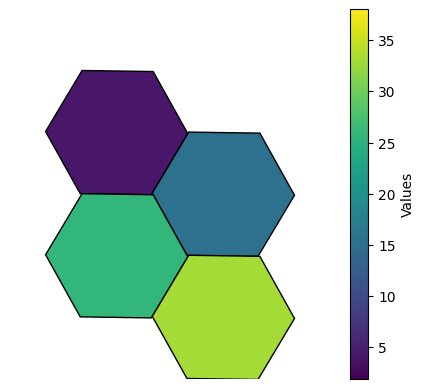

2024-05-16 08:07:15.996996: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-16 08:07:15.997030: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-05-16 08:07:15.997037: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-05-16 08:07:15.997120: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-05-16 08:07:15.997145: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-05-16 08:07:15.997150: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [2]:
# Distribution Settings
scale = 1
means = [5, 15, 25, 35]

normal_4 = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]
sample_and_plot(normal_4)

S=4
# Historical data as features
H=2
# Total timepoints in data
T = 1000

train_dataset, val_dataset, test_dataset, (train_X_THS, train_y_TS), (val_X_THS, val_y_TS), (test_X_THS, test_y_TS) = example_datasets(H, T, dist_S=normal_4, return_numpy=True)

In [3]:
print(f'Training shape {train_X_THS.shape}, {train_y_TS.shape}')

Training shape (600, 2, 4), (600, 4)


In [4]:
class LocSpecificMixWeights(keras.layers.Layer):
    """Dumb layer that just returns mixture weights
    Constrained to unit norm
    """
    def __init__(self, num_locations, num_components=2, **kwargs):
        super().__init__(**kwargs)
        self.w = self.add_weight(name='shared_mix_weights',
            shape=(num_locations, num_components ),
            initializer="uniform",
            trainable=True,
        )
        
        self.softmax = keras.layers.Softmax(axis=1)

    def call(self, inputs):
        return self.softmax(self.w)

def build_mixture_normal(parameter_model, input_shape, scale=1, num_components=4, seed=360):
    num_features, num_locations = input_shape
    member_models = []
    for c in range(num_components):
        member_models.append(parameter_model(input_shape, seed=seed+1000*c))

    # Define layers
    inputs = keras.Input(shape=input_shape, name='mix_input')
    reshape_layer = keras.layers.Reshape(name='mix_reshape', target_shape=(-1,1))
    concat_layer = keras.layers.Concatenate(name='mix_concat',axis=-1)

    mixture_weight_layer = LocSpecificMixWeights(num_locations, name='mixture_weights', num_components=num_components)

    reshaped = [reshape_layer(member(inputs)) for member in member_models]
    concatted = concat_layer(reshaped)
    
    mixture_weights = mixture_weight_layer(inputs)

    mixture_distribution_layer = tfp.layers.DistributionLambda(lambda params: 
        tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=params[0]),
                                            components_distribution = tfp.distributions.Normal(loc=params[1], scale=scale, validate_args=True)))
    
    outputs = mixture_distribution_layer([mixture_weights, concatted])

    model = keras.Model(name='mixture_model', inputs=inputs, outputs=[outputs])

    return model 



In [5]:
model = build_mixture_normal(location_specific_linear, (H, S),scale=scale, num_components=4)

In [6]:
model.trainable_variables

[<tf.Variable 'linear_convolution/kernel:0' shape=(1, 2, 1) dtype=float32, numpy=
 array([[[ 0.3766508],
         [-0.5381606]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 2, 1) dtype=float32, numpy=
 array([[[1.3645188 ],
         [0.97905266]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 2, 1) dtype=float32, numpy=
 array([[[ 0.5395056 ],
         [-0.04774225]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 2, 1) dtype=float32, numpy=
 array([[[-1.2136158 ],
         [ 0.50972867]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32

In [7]:
# Set linear weights to 0
for index in [0, 2, 4, 6]:
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tf.zeros(variable.shape))

Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/kernel:0
Shape: (1, 2, 1)
Name: linear_convolution/kernel:0
Shape: (1, 2, 1)


In [8]:
# set biases to true value
for index, bias in zip([1, 3, 5, 7], [5.0, 15.0, 25.0, 35.0]):
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tfp.math.softplus_inverse([bias]))

Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)


In [9]:
index = -1
variable = model.trainable_variables[index]
print(f'Name: {variable.name}')
print(f'Shape: {variable.shape}')

weights = tf.eye(4)

variable.assign(tf.math.log(weights+1e-13))

Name: shared_mix_weights:0
Shape: (4, 4)


<tf.Variable 'UnreadVariable' shape=(4, 4) dtype=float32, numpy=
array([[  0.      , -29.933605, -29.933605, -29.933605],
       [-29.933605,   0.      , -29.933605, -29.933605],
       [-29.933605, -29.933605,   0.      , -29.933605],
       [-29.933605, -29.933605, -29.933605,   0.      ]], dtype=float32)>

In [10]:
mixture_model = model(train_X_THS)

In [11]:
num_score_func_samples=2

In [12]:
sample_y_MBS = mixture_model.sample(num_score_func_samples)
print(f'Sample y shape {sample_y_MBS.shape}')


sample_log_probs_MBS = mixture_model.log_prob(sample_y_MBS)

# no cross-ratio decision here
sample_decisions_MBS = tf.identity(sample_y_MBS)
expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)
print(f'Expected decisions shape {expected_decisions_BS.shape}')
loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
loss = tf.reduce_mean(loss_B)

Sample y shape (2, 600, 4)
Expected decisions shape (600, 4)


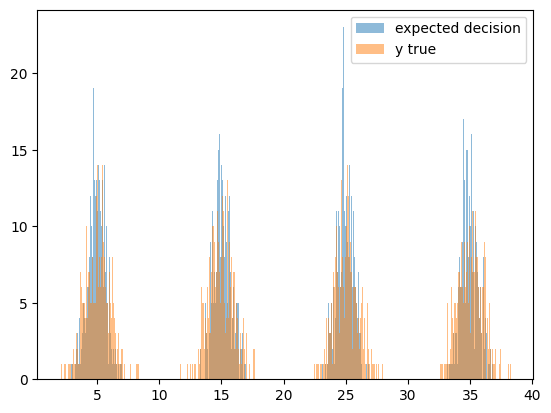

In [13]:
plt.hist(tf.reshape(expected_decisions_BS, [-1]).numpy(),alpha=0.5, bins=1000, label='expected decision')
plt.hist(tf.reshape(train_y_TS, [-1]).numpy(),alpha=0.5, bins=1000, label='y true')
plt.legend()

In [58]:
gradient_magnitudes = []
master_magnitudes = []
param_vals = []
losses = []
mean_log_probs = []
for param_value in np.linspace(20, 30, 50, dtype=np.float32):
    print(param_value)
    variable = model.trainable_variables[5]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')
    variable.assign(tfp.math.softplus_inverse([param_value]))
    
    start = time.time()

    for sample in range(1):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
            mixture_model = model(train_X_THS)

            sample_y_MBS = mixture_model.sample(num_score_func_samples)
            sample_log_probs_MBS = mixture_model.log_prob(sample_y_MBS)

            # no cross-ratio decision here
            sample_decisions_MBS = tf.identity(sample_y_MBS)
            expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

            loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
            loss = tf.reduce_mean(loss_B)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        master_gradient = master_tape.gradient(loss_B, model.trainable_weights)

        param_vals.append(param_value)
        gradient_magnitudes.append(overall_gradient[5])
        master_magnitudes.append(master_gradient[5])
        losses.append(loss)
        mean_log_probs.append(tf.reduce_mean(sample_log_probs_MBS[:,:,2]))
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

20.0
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.6849915981292725
20.204082
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.786661148071289
20.408163
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.7557086944580078
20.612246
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.6399612426757812
20.816326
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.915081262588501
21.020409
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.643824815750122
21.22449
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.7153124809265137
21.428572
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.7129714488983154
21.632652
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.6473028659820557
21.836735
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 2.5882837772369385
22.040817
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.6830267906188965
22.244898
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed t

In [48]:
jacobian_pMBS[5][0,0,:]

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [2.8460057e-18]], dtype=float32)>

In [57]:
sample_log_probs_MBS[:,:,0]

<tf.Tensor: shape=(2, 600), dtype=float32, numpy=
array([[-1.4129745, -0.9653251, -1.0670345, ..., -1.191466 , -1.0672827,
        -1.1722648],
       [-2.170496 , -1.0497558, -1.2191709, ..., -1.813071 , -0.9340248,
        -0.9299537]], dtype=float32)>

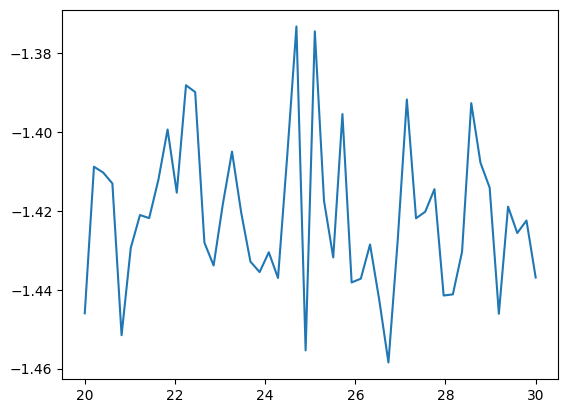

In [59]:
plt.plot(param_vals, mean_log_probs)

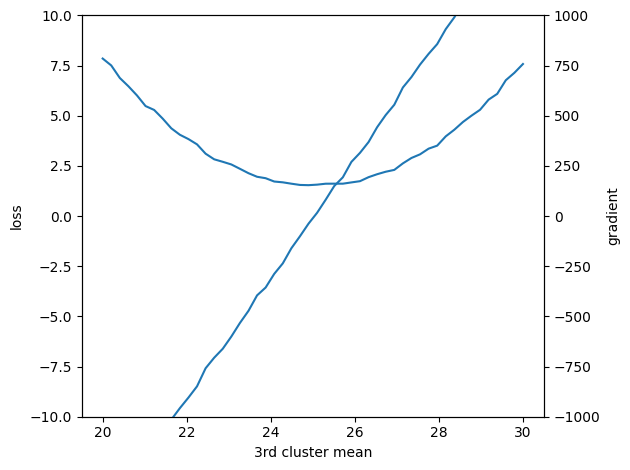

In [43]:
# plot with 2 different scales, 1 y axis for each graph:
fig, ax1 = plt.subplots()

# Plot the first line on ax1
ax1.set_xlabel('3rd cluster mean')
ax1.set_ylabel('loss')
ax1.plot(param_vals, losses)
ax1.tick_params(axis='y')
ax1.set_ylim([-10, 10])

# Create ax2, which shares the same x-axis as ax1
ax2 = ax1.twinx()
ax2.set_ylabel('gradient')
ax2.plot(param_vals, master_magnitudes)
ax2.tick_params(axis='y')

ax2.set_ylim([-1000, 1000])

fig.tight_layout()
plt.show()


In [14]:

times = []
for num_score_func_samples in range(5, 50):

    with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape:
        mixture_model = model(train_X_THS)

        sample_y_MBS = mixture_model.sample(num_score_func_samples)
        sample_log_probs_MBS = mixture_model.log_prob(sample_y_MBS)

        # no cross-ratio decision here
        sample_decisions_MBS = tf.identity(sample_y_MBS)
        expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

        loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
        loss = tf.reduce_mean(loss_B)

    # time calculation
    start = time.time()
    jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
    end = time.time()
    elapsed = end - start
    print(f'Jacobian time {elapsed} for {num_score_func_samples} samples')
    times.append(elapsed)


Jacobian time 8.638091564178467 for 5 samples
Jacobian time 11.695404291152954 for 6 samples
Jacobian time 15.843820571899414 for 7 samples


In [28]:
gradient_magnitudes = []
param_vals = []
losses = []
for param_value in [25.0]:
    print(param_value)
    variable = model.trainable_variables[5]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')
    variable.assign(tfp.math.softplus_inverse([param_value]))
    
    start = time.time()

    for sample in range(1):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape:
            mixture_model = model(train_X_THS)

            sample_y_MBS = mixture_model.sample(num_score_func_samples)
            sample_log_probs_MBS = mixture_model.log_prob(sample_y_MBS)

            # no cross-ratio decision here
            sample_decisions_MBS = tf.identity(sample_y_MBS)
            expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

            loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
            loss = tf.reduce_mean(loss_B)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        param_vals.append(param_value)
        gradient_magnitudes.append(overall_gradient[5])
        losses.append(loss)
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

25.0
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 2.6471095085144043


In [30]:
overall_gradient[5]overall_gradientoverall_gradient

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.8441185e-18], dtype=float32)>

In [50]:
param_value

30.0

In [72]:
gradient_magnitudes = []
master_magnitudes = []
param_vals = []
losses = []
mean_log_probs = []
for param_value in np.linspace(20, 30, 50, dtype=np.float32):
    print(param_value)
    variable = model.trainable_variables[5]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')
    variable.assign(tfp.math.softplus_inverse([param_value]))
    
    start = time.time()

    for sample in range(1):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
            mixture_model = model(train_X_THS)

            sample_y_MBS = mixture_model.sample(num_score_func_samples)
            sample_log_probs_MBS = mixture_model.log_prob(sample_y_MBS)

            # no cross-ratio decision here
            sample_decisions_MBS = tf.identity(sample_y_MBS)
            expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

            loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
            loss = tf.reduce_mean(loss_B)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        master_gradient = master_tape.gradient(loss_B, model.trainable_weights)

        param_vals.append(param_value)
        #gradient_magnitudes.append(overall_gradient[5])
        master_magnitudes.append(master_gradient[5])
        losses.append(loss)
        mean_log_probs.append(tf.reduce_mean(sample_log_probs_MBS[:,:,2]))
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

20.0
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.7187938690185547
20.204082
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.8008003234863281
20.408163
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.8468332290649414
20.612246
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.721468448638916
20.816326
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.825305461883545
21.020409
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.701967477798462
21.22449
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.7718505859375
21.428572
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.7736587524414062
21.632652
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.6996605396270752
21.836735
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 1.784508228302002
22.040817
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 2.9216787815093994
22.244898
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 

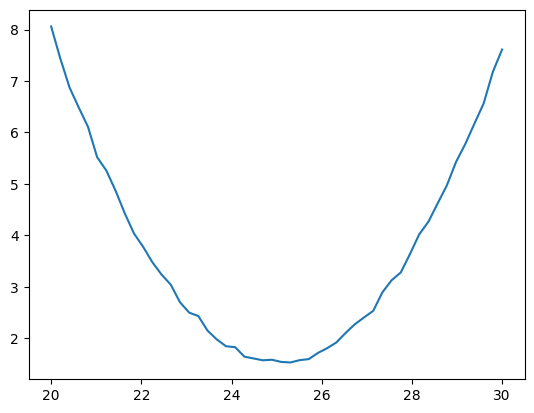

In [61]:
plt.plot(param_vals, losses)

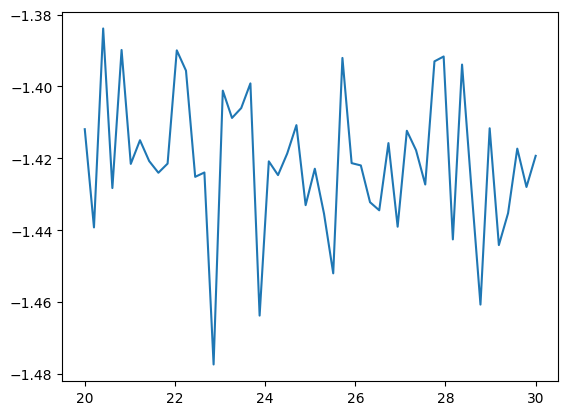

In [64]:
plt.plot(param_vals, mean_log_probs)


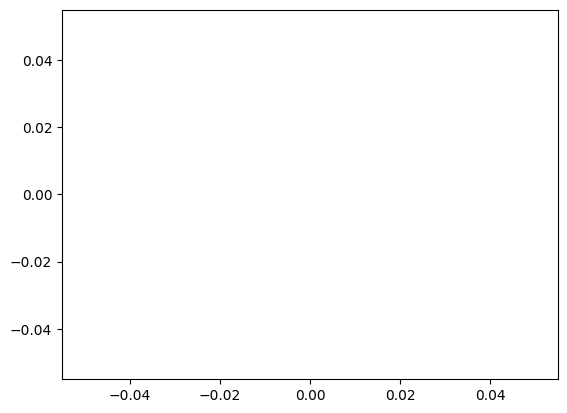

In [70]:
plt.plot(param_vals, master_magnitudes)

In [68]:
sample_log_probs_MBS[:,0,:]

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.96249604, -1.2357901 , -0.96590775, -1.1359234 ],
       [-1.6726912 , -2.0344315 , -1.3133397 , -1.342358  ]],
      dtype=float32)>

In [69]:
sample_y_MBS[:,0,:]

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 4.7048473, 15.796055 , 29.693506 , 34.341236 ],
       [ 6.227805 , 16.493649 , 29.111855 , 35.92024  ]], dtype=float32)>

In [71]:
master_gradient

[None, None, None, None, None, None, None, None, None]

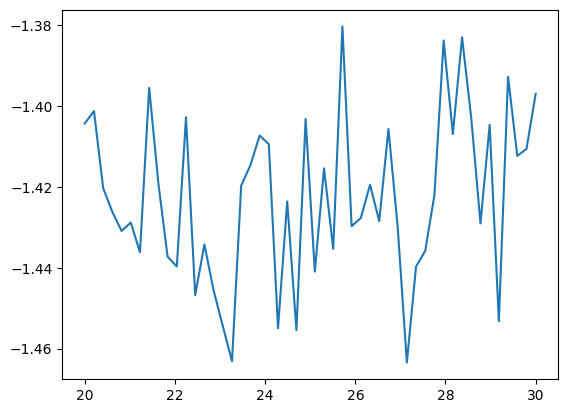

In [73]:
plt.plot(param_vals, mean_log_probs)

In [155]:
@tf.function
def overall_gradient_calculation(gradient_BSp, decision_gradient_BS):
    num_param_dims = tf.rank(gradient_BSp)-2
    num_param_dims_tf = tf.cast(num_param_dims, tf.int32)
    new_shape = tf.concat([tf.shape(decision_gradient_BS), tf.ones([num_param_dims_tf], tf.int32)], axis=0)
    decision_gradient_BSp=tf.reshape(decision_gradient_BS, new_shape)
    #decision_gradient_BSp = tf.reshape(decision_gradient_BS, decision_gradient_BS.shape + [1]*num_param_dims.numpy())

    overall_gradient_BSp = gradient_BSp*decision_gradient_BSp

    # sum over batch and location
    overall_gradient = tf.reduce_mean(overall_gradient_BSp, axis=[0,1])
    return overall_gradient

In [156]:
num_score_func_samples=2

Our objective is to minimize the loss incurred by action $\theta$ under outcome $y_t$, where $\theta$ is a function of a model with parameters $\phi$, $\theta(\phi) = f(\hat{y}), \hat{y}\sim p_\phi$.
$$\min_\phi \sum^T \mathcal{L}(\theta(\phi), y_t)$$

We can use stochastic gradient descent to solve this optimization problem
$$\nabla_\phi \mathcal{L}(\theta(\phi), y_t) = \nabla_\phi \theta \nabla_\theta \mathcal{L} $$

Calculating $\nabla_\phi \theta$ requires use of the score function (or REINFORCE) estimator:
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (\nabla_\phi \log p_\phi(y^m) )f(y^m)$$

This makes our overall gradient calculation:
$$\nabla_\phi \mathcal{L}(\theta(\phi), y_t) =  \nabla_\theta \mathcal{L}\frac{1}{M} \sum_{m=1}^M (\nabla_\phi \log p_\phi(y^m) )f(y^m) $$

We can visualize all the quantities below

In [157]:
my_gradient_calc = []
true_gradient_calc = []
param_vals = []
losses = []
log_prob_samples = []
jacobian_vals = []
mean_decisions = []
mean_param_grad = []
mean_loss_grad = []
for param_value in np.linspace(20, 30, 10, dtype=np.float32):
    print(param_value)
    variable = model.trainable_variables[5]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')
    variable.assign(tfp.math.softplus_inverse([param_value]))
    
    start = time.time()

    for sample in range(10):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
            mixture_model = model(train_X_THS)

            sample_y_MBS = mixture_model.sample(num_score_func_samples)
            stopped_samples = tf.stop_gradient(sample_y_MBS)
            sample_log_probs_MBS = mixture_model.log_prob(stopped_samples)

            # no cross-ratio decision here. Do want gradients in these tensors
            sample_decisions_MBS = tf.identity(sample_y_MBS)
            expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

            loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
            loss = tf.reduce_mean(loss_B)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        master_gradient = master_tape.gradient(loss_B, model.trainable_weights)

        param_vals.append(param_value)
        my_gradient_calc.append(overall_gradient[5])
        true_gradient_calc.append(master_gradient[5])
        losses.append(loss)
        log_prob_samples.append(tf.reduce_mean(sample_log_probs_MBS[:,:,2]))
        jacobian_vals.append(tf.reduce_mean(jacobian_pMBS[5][:,:,2]))
        mean_param_grad.append(tf.reduce_mean(param_gradient_pBS[5][:,2]))
        mean_decisions.append(tf.reduce_mean(sample_decisions_MBS[:,:,2]))
        mean_loss_grad.append(tf.reduce_mean(loss_gradients_BS[:,2]))
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

20.0
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 16.486435890197754
21.11111
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 16.267884254455566
22.222221
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 16.89740777015686
23.333334
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 16.344967365264893
24.444445
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 16.423786401748657
25.555555
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 16.13601803779602
26.666666
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 16.29530668258667
27.777779
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 16.467843770980835
28.88889
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 16.355766534805298
30.0
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 17.4377543926239


Text(0.5, 1.0, '$\\log p(y^m)$ Average log prob of score function samples')

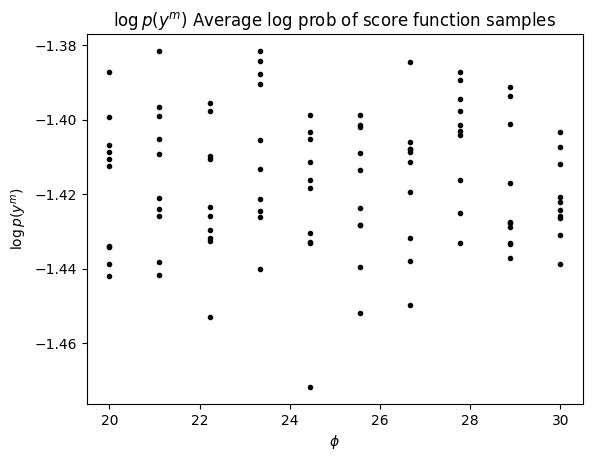

In [158]:
plt.plot(param_vals, log_prob_samples, 'k.')
plt.ylabel('$\log p(y^m)$')
plt.xlabel('$\phi$')
plt.title("$\log p(y^m)$ Average log prob of score function samples")

Text(0.5, 1.0, '$\\nabla_\\phi \\log p(y^m)$ gradient of  log prob of score function samples')

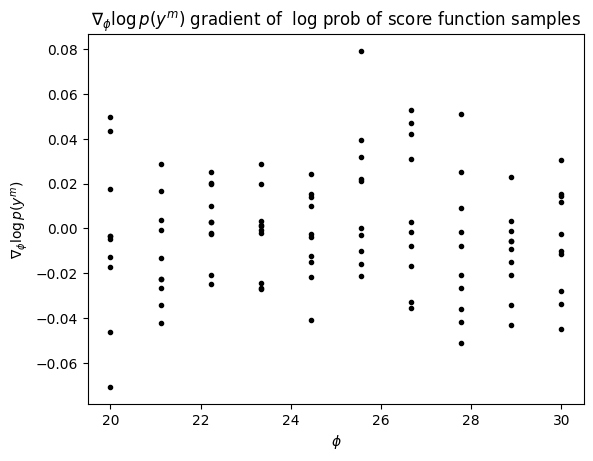

In [159]:
plt.plot(param_vals, jacobian_vals,'k.')
plt.ylabel(r'$\nabla_\phi \log p(y^m)$')
plt.xlabel('$\phi$')
plt.title(r"$\nabla_\phi \log p(y^m)$ gradient of  log prob of score function samples")

Text(0.5, 1.0, "$f(y^m)$ Average 'decision' ")

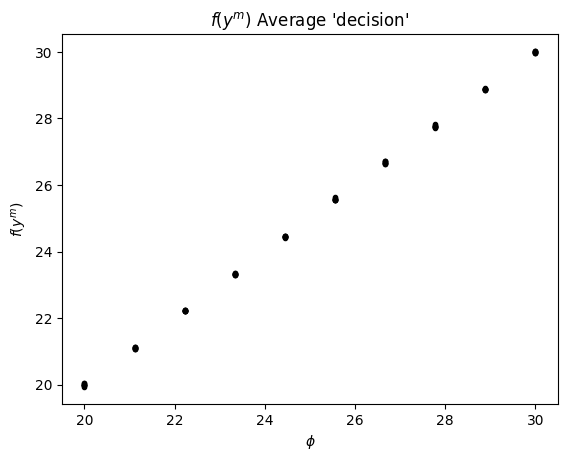

In [160]:
plt.plot(param_vals, mean_decisions ,'k.')
plt.ylabel('$f(y^m)$')
plt.xlabel('$\phi$')
plt.title("$f(y^m)$ Average 'decision' ")


In [1]:
plt.plot(param_vals, mean_param_grad, 'k.')
plt.ylabel(r'$\nabla_\phi \theta$')
plt.xlabel('$\phi$')
plt.title(r"$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (\nabla_\phi \log p_\phi(y^m) )f(y^m)$ Score function estimator of gradient of decision ")

NameError: name 'plt' is not defined

Text(0.5, 1.0, '$\\nabla_\\theta \\mathcal{L} $ Gradient of loss w.r.t decision')

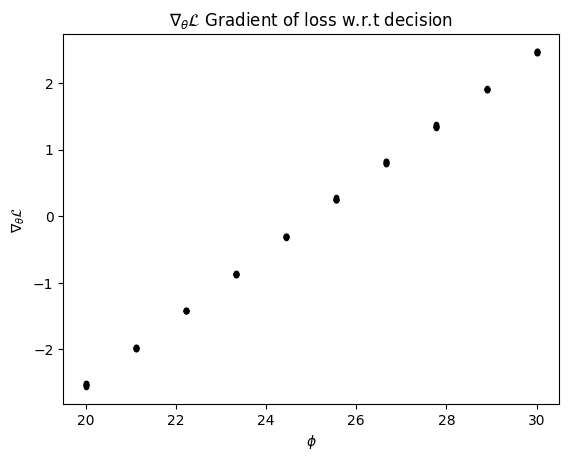

In [162]:
plt.plot(param_vals, mean_loss_grad, 'k.')
plt.ylabel(r'$\nabla_\theta \mathcal{L} $')
plt.xlabel('$\phi$')
plt.title(r"$\nabla_\theta \mathcal{L} $ Gradient of loss w.r.t decision")

Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{L} $ Overall gradient w.r.t model parameters')

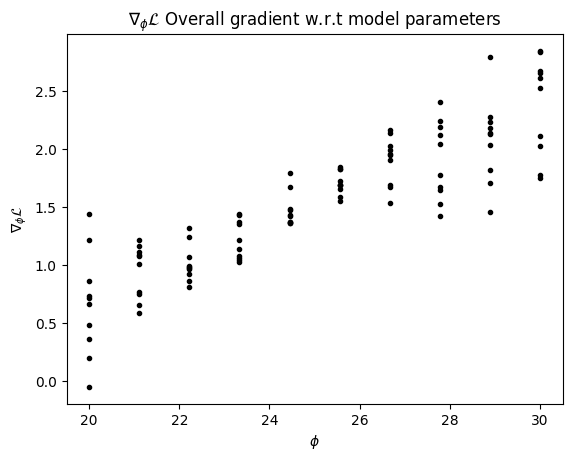

In [163]:
plt.plot(param_vals, my_gradient_calc, 'k.')
plt.ylabel(r'$\nabla_\phi \mathcal{L} $')
plt.xlabel('$\phi$')
plt.title(r"$\nabla_\phi \mathcal{L} $ Overall gradient w.r.t model parameters")

Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{L} $ Overall gradient w.r.t model parameters true derivative')

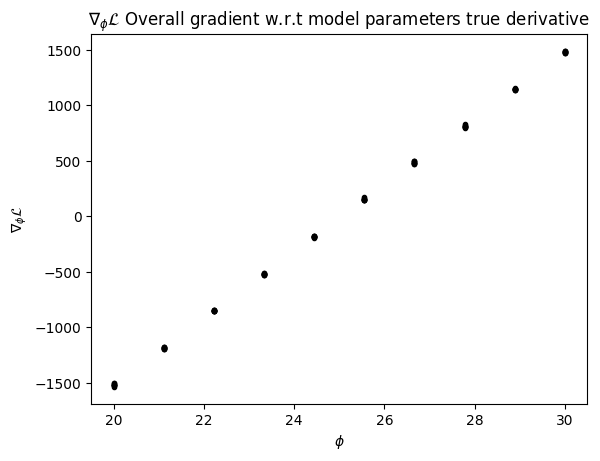

In [164]:
plt.plot(param_vals, true_gradient_calc, 'k.')
plt.ylabel(r'$\nabla_\phi \mathcal{L} $')
plt.xlabel('$\phi$')
plt.title(r"$\nabla_\phi \mathcal{L} $ Overall gradient w.r.t model parameters true derivative")

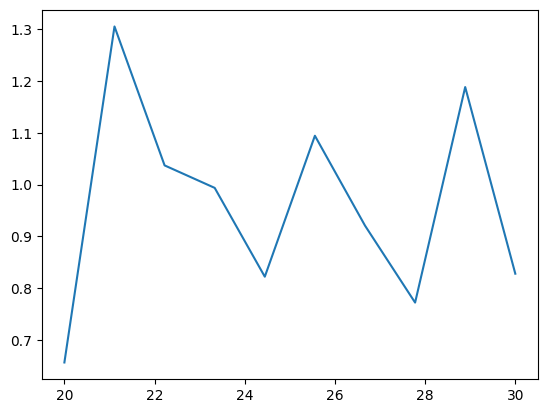

In [115]:
plt.plot(param_vals, mean_param_grad)

In [136]:
gradient_magnitudes

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.3922069], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.98049986], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00599131], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.227577], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.5317818], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.2237928], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.4643743], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.038371], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.2455573], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.632099], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.585091], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.971228], dtype=float32)>,
 <tf.Tensor: s

In [139]:
overall_gradient[5].numpy().squeeze()

array(4.136614, dtype=float32)

ValueError: x and y must have same first dimension, but have shapes (10,) and (20, 1)

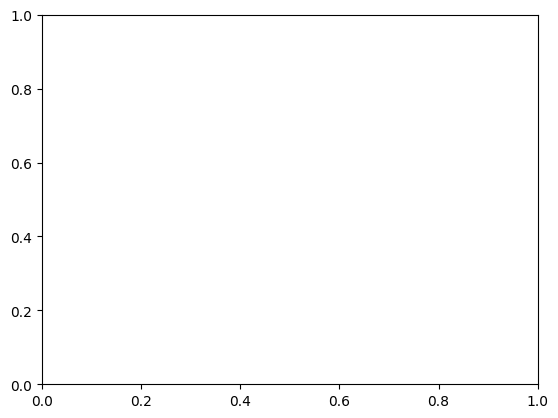

In [142]:
plt.plot(param_vals, [mag.numpy() for mag in master_magnitudes])

In [144]:
master_gradient[5]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1482.389], dtype=float32)>

In [145]:
param_vals

[20.0,
 21.11111,
 22.222221,
 23.333334,
 24.444445,
 25.555555,
 26.666666,
 27.777779,
 28.88889,
 30.0]

In [22]:
# TODO DEBUG 23 

In [125]:
num_score_func_samples = 7
for param_value in [23.0]:
    print(param_value)
    variable = model.trainable_variables[5]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')
    variable.assign(tfp.math.softplus_inverse([param_value]))
    
    start = time.time()

    for sample in range(1):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
            mixture_model = model(train_X_THS)

            sample_y_MBS = mixture_model.sample(num_score_func_samples)
            stopped_samples = tf.stop_gradient(sample_y_MBS)
            sample_log_probs_MBS = mixture_model.log_prob(stopped_samples)

            # no cross-ratio decision here. Do want gradients in these tensors
            sample_decisions_MBS = tf.identity(sample_y_MBS)
            expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

            loss_B = keras.losses.mean_squared_error(train_y_TS, expected_decisions_BS)
            loss = tf.reduce_mean(loss_B)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        master_gradient = master_tape.gradient(loss_B, model.trainable_weights)


    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

23.0
Name: linear_convolution/bias:0
Shape: (1,)
Elapsed time 15.95554780960083


In [126]:
loss_gradients_BS[:,:].numpy().mean(axis=0).round(2)

array([-0.01,  0.02, -1.03, -0.02], dtype=float32)

In [127]:
np.squeeze(param_gradient_pBS[5].numpy())[:,:].mean(axis=0).round(2)

array([ 0.  , -0.  ,  1.14,  0.  ], dtype=float32)

In [128]:

    num_param_dims = tf.rank(param_gradient_pBS[5])-2
    num_param_dims_tf = tf.cast(num_param_dims, tf.int32)
    new_shape = tf.concat([tf.shape(loss_gradients_BS), tf.ones([num_param_dims_tf], tf.int32)], axis=0)
    decision_gradient_BSp=tf.reshape(loss_gradients_BS, new_shape)
    #decision_gradient_BSp = tf.reshape(decision_gradient_BS, decision_gradient_BS.shape + [1]*num_param_dims.numpy())

    overall_gradient_BSp = param_gradient_pBS[5]*decision_gradient_BSp


In [129]:
decision_gradient_BSp[:,:].numpy().mean(axis=0).round(2)

array([[-0.01],
       [ 0.02],
       [-1.03],
       [-0.02]], dtype=float32)

In [130]:
np.squeeze(overall_gradient_BSp.numpy())[:,:].mean(axis=0).round(2)

array([ 0.  , -0.  ,  0.62, -0.  ], dtype=float32)

In [131]:
param_gradient_pBS[5].shape

TensorShape([600, 4, 1])

In [132]:
decision_gradient_BSp.shape

TensorShape([600, 4, 1])

In [133]:
row_idx = 7
param_grad_row = np.squeeze(param_gradient_pBS[5].numpy()).round(2)[row_idx,:]
print(param_grad_row)
decision_grad_row = np.squeeze(decision_gradient_BSp[row_idx,:].numpy()).round(2)
print(decision_grad_row)

[ 0.   -0.    3.83  0.  ]
[-0.56 -0.97 -0.41 -0.76]


In [143]:
np.squeeze(overall_gradient_BSp.numpy()).round(2)[row_idx,:]

array([-0.  ,  0.  , -1.57, -0.  ], dtype=float32)

In [135]:
param_grad_row*decision_grad_row

array([-0.    ,  0.    , -1.5703, -0.    ], dtype=float32)

In [139]:
overall_gradient_BSp.numpy()[row_idx,:].round(2)

array([[-0.  ],
       [ 0.  ],
       [-1.57],
       [-0.  ]], dtype=float32)

In [142]:
overall_gradient_BSp.numpy().sum(axis=1).mean()

0.61574644

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  3.,  1.,  1.,  0.,  1.,
         1.,  5.,  4., 10.,  6.,  5.,  5.,  6., 11.,  8., 11., 18., 14.,
        23., 19., 31., 29., 26., 29., 35., 30., 23., 22., 22., 13., 19.,
        17., 13., 10.,  8., 11., 11., 14.,  8.,  9.,  5.,  5.,  5.,  3.,
         4.,  4.,  2.,  8.,  3.,  0.,  0.,  2.,  1.,  4.,  3.,  1.,  1.,
         1.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([-38.95807648, -38.12091827, -37.28376007, -36.44659805,
        -35.60943985, -34.77228165, -33.93512344, -33.09796143,
        -32.26080322, -31.42364502, -30.58648491, -29.74932671,
        -28.9121666 , -28.07500839, -27.23785019, -26.40069008,
        -25.56353188, -24.72637177, -23.88921356, -23.05205345,
        -22.21489525, -21.37773514, -20.54057693, -19.70341682,
        -18.86625862, -18.02909851, -17.19194031, 

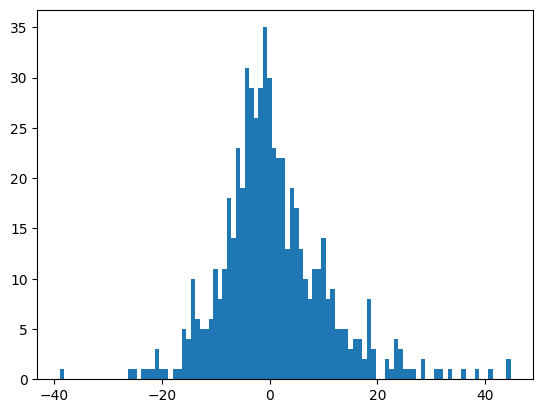

In [147]:
plt.hist(overall_gradient_BSp.numpy()[:,2,0], bins=100)

In [150]:
param_gradient_pBS[5].numpy()[:,2,0].mean()

1.1359869

In [19]:
model = keras.Sequential()
model.add(keras.layers.Embedding(2, 200))
# The model will take as input an integer matrix of size (batch,
# input_length), and the largest integer (i.e. word index) in the input
# should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where `None` is the batch
# dimension.
input_array = np.random.randint(2, size=(32, 1))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)


1/1 [==============================] - 0s 42ms/step
(32, 1, 200)


In [21]:
model.layers[0].trainable_variables

[<tf.Variable 'embedding_8/embeddings:0' shape=(2, 200) dtype=float32, numpy=
 array([[ 4.00710367e-02,  2.17983611e-02,  1.88720562e-02,
          2.82516517e-02,  3.93441953e-02,  4.10812162e-02,
          2.75951736e-02,  3.73969711e-02, -1.85195692e-02,
         -3.68407741e-02, -1.98698994e-02,  2.21048258e-02,
          2.13340409e-02, -9.10874456e-03, -9.20568779e-03,
          2.12403797e-02, -3.52883823e-02, -1.08296275e-02,
         -2.65578162e-02, -3.56816426e-02, -3.81036289e-02,
          4.17583697e-02,  4.31665517e-02, -3.37139741e-02,
         -8.98314640e-03,  2.37796791e-02, -5.77997416e-04,
         -1.69084668e-02, -1.70904398e-03, -2.72422433e-02,
          1.33107565e-02,  2.97325961e-02,  4.26869467e-03,
         -1.98104512e-02,  3.50488462e-02,  6.26279041e-03,
          9.15516540e-03, -3.89689319e-02, -3.84410135e-02,
          2.36745216e-02,  2.15427168e-02,  1.22919902e-02,
          2.16713808e-02, -2.86104809e-02, -2.81129479e-02,
          1.71050765e-

In [28]:
model = keras.Sequential()
model.add(keras.layers.Dense(512))
# The model will take as input an integer matrix of size (batch,
# input_length), and the largest integer (i.e. word index) in the input
# should be no larger than 999 (vocabulary size).
# Now model.output_shape is (None, 10, 64), where `None` is the batch
# dimension.
input_array = np.random.randint(2, size=(32, 100))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(model.layers[0].trainable_variables[0])


1/1 [==============================] - 0s 45ms/step
<tf.Variable 'dense_6/kernel:0' shape=(100, 512) dtype=float32, numpy=
array([[ 0.06401158, -0.05931326, -0.05300356, ...,  0.02170867,
         0.06918708,  0.07211449],
       [ 0.05404121, -0.00382126,  0.05016062, ..., -0.04697246,
        -0.06687244, -0.00333255],
       [ 0.06922463, -0.07348624,  0.03098077, ..., -0.04589643,
         0.01232717,  0.07443259],
       ...,
       [-0.00049403,  0.07945058,  0.01897515, ..., -0.07735568,
         0.08295865,  0.01697984],
       [-0.05522368, -0.0405695 , -0.04728967, ...,  0.0146319 ,
         0.0904562 ,  0.09621247],
       [-0.06007161,  0.07647712, -0.09723961, ...,  0.03532358,
         0.03829072,  0.01316104]], dtype=float32)>


In [30]:
T = 100
dense = T*512+512 + (512*512+512*3)

In [ ]:
embeddings = T*400